In [1]:
from transfer_em.datasets import datasets, generators
from transfer_em.debug import generate_images
from transfer_em.cgan import EM2EM
from transfer_em import debug

import tensorflow as tf
import time

### Setup input and output domain datasets for training and testing

In [2]:
# location of service front-end to ng precomputed
cloudrun = "https://transferem-bmcp5imp6q-uk.a.run.app"

# create dataset of 3D datasets from two datasets stored in neuroglancer's precomputed format (assume gcs location)
dataset_x_location = "neuroglancer-janelia-flyem-hemibrain/emdata/raw/jpeg"

# use a dataset with a different contrast adjustment
dataset_y_location = "neuroglancer-janelia-flyem-hemibrain/emdata/clahe_yz/jpeg"

# crude bbox for hemibrain
bbox = ((8000, 14000, 13000), (30000, 28000, 25000)) # x,y,z, x2,y2,z2

# 132x132x132 cube is minimum allowable size (use small batches)
generator = generators.volume3d_ng(dataset_x_location, bbox, 132, cloudrun=cloudrun)

# will take some time to download the whole dataset for the first time; just do a really small epoch size of 2
start = time.time()
train_x, meanstd_x = datasets.create_dataset_from_generator(generator, (132,132,132), batch_size=1, epoch_size=2)
print(time.time() - start)

# keep track of this when running inference
print(f"meanstd_x: {meanstd_x}")

# 132x132x132 cube is minimum allowable size (use small batches)
generator = generators.volume3d_ng(dataset_y_location, bbox, 132, cloudrun=cloudrun)
train_y, meanstd_y = datasets.create_dataset_from_generator(generator, (132,132,132), batch_size=1, epoch_size=2)

# keep track of this when running inference
print(f"meanstd_y: {meanstd_y}")


12.783818006515503
meanstd_x: (<tf.Tensor: shape=(), dtype=float32, numpy=0.14880067>, <tf.Tensor: shape=(), dtype=float32, numpy=0.18330409>)
meanstd_y: (<tf.Tensor: shape=(), dtype=float32, numpy=0.06789228>, <tf.Tensor: shape=(), dtype=float32, numpy=0.49938157>)


In [6]:
# create a test set for evaluation -- set seed to get same sequence

generator = generators.volume3d_ng(dataset_y_location, bbox, 132, seed=10, cloudrun=cloudrun)
test_x, _ = datasets.create_dataset_from_generator(generator, (132,132,132), batch_size=1, epoch_size=1, meanstd=meanstd_x)


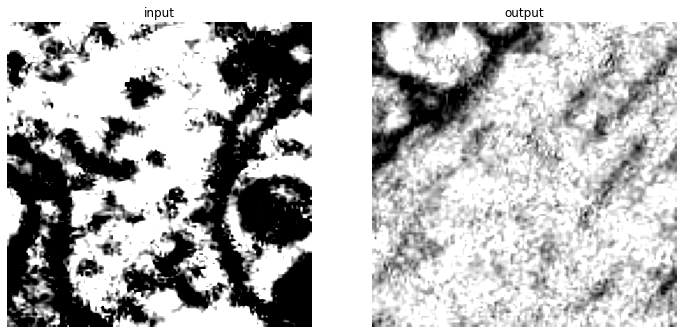

In [7]:
# get a sample from the test dataset and view
sample = next(iter(test_x))
sample_target = next(iter(train_y))

generate_images(sample, sample_target)

### Create model and test (saves checkpoints)

In [5]:
# create EM2EM network with 132x132 image and provide an experiment name for checkpointing
em2em = EM2EM(132, "hemi2hemi_nonorm1", is3d=True)

In [6]:
# train for 1 EPOCH
em2em.train(train_x, train_y, 5, 0, False, num_samples=2)

Epoch 1 loss: 28.385454177856445
Saving checkpoint for epoch 1 at ./checkpoints/train_hemi2hemi_nonorm1/ckpt-1
Time taken for epoch 1 is 61.88273501396179
Epoch 2 loss: 24.748462677001953
Saving checkpoint for epoch 2 at ./checkpoints/train_hemi2hemi_nonorm1/ckpt-2
Time taken for epoch 2 is 34.04588198661804
Epoch 3 loss: 31.62959861755371
Saving checkpoint for epoch 3 at ./checkpoints/train_hemi2hemi_nonorm1/ckpt-3
Time taken for epoch 3 is 41.58722686767578
Epoch 4 loss: 22.323863983154297
Saving checkpoint for epoch 4 at ./checkpoints/train_hemi2hemi_nonorm1/ckpt-4
Time taken for epoch 4 is 38.26365399360657
Epoch 5 loss: 26.468841552734375
Saving checkpoint for epoch 5 at ./checkpoints/train_hemi2hemi_nonorm1/ckpt-5
Time taken for epoch 5 is 39.288708209991455


### Run inference directly using the model

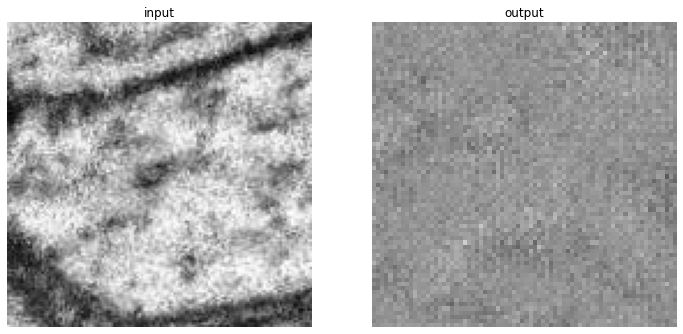

In [7]:
# run prediction on the sample (64 image batch)
sample_pred = em2em.predict(sample)

#print(sample_pred)

# rescale based on f's meanstd
sample_unstd = datasets.unstandardize_population(sample, meanstd_x)

# rescale prediction based on g's meanstd
sample_pred_unstd = datasets.unstandardize_population(sample_pred, meanstd_y)

# view final results
generate_images(sample_unstd, sample_pred_unstd)

### Run inference using prediction utility

* reload model from a given checkpoint
* run inference for a large cube

In [12]:
from transfer_em.utils import predict_ng_cube

# read first checkpoint (TODO: allow user to not require re-adding EM2EM parameters)
model = EM2EM(132, "hemi2hemi_nonorm", is3d=True, ckpt_restore="./checkpoints/train_hemi2hemi_nonorm1/ckpt-5")

# utility will take care of chunking the request
test_in, test_out = predict_ng_cube(dataset_x_location, (8000, 14000, 13000), (72, 72, 72),
                model, meanstd_x, meanstd_y, cloudrun=cloudrun, fetch_input=True)

"""test_in1, test_out1 = predict_ng_cube(dataset_x_location, (8010, 14010, 13010), (74, 74, 74),
                model, meanstd_x, meanstd_y, cloudrun=cloudrun, fetch_input=True)
test_in2, test_out2 = predict_ng_cube(dataset_x_location, (8012, 14012, 13012), (74, 74, 74),
                model, meanstd_x, meanstd_y, cloudrun=cloudrun, fetch_input=True)
test_in3, test_out3 = predict_ng_cube(dataset_x_location, (8003, 14003, 13003), (74, 74, 74),
                model, meanstd_x, meanstd_y, cloudrun=cloudrun, fetch_input=True)
test_in4, test_out4 = predict_ng_cube(dataset_x_location, (8004, 14004, 13004), (74, 74, 74),
                model, meanstd_x, meanstd_y, cloudrun=cloudrun, fetch_input=True)
test_in5, test_out5 = predict_ng_cube(dataset_x_location, (8005, 14005, 13005), (74, 74, 74),
                model, meanstd_x, meanstd_y, cloudrun=cloudrun, fetch_input=True)"""

checkpoint ./checkpoints/train_hemi2hemi_nonorm/ckpt-5 restored
Latest checkpoint restored!!


'test_in1, test_out1 = predict_ng_cube(dataset_x_location, (8010, 14010, 13010), (74, 74, 74),\n                model, meanstd_x, meanstd_y, cloudrun=cloudrun, fetch_input=True)\ntest_in2, test_out2 = predict_ng_cube(dataset_x_location, (8012, 14012, 13012), (74, 74, 74),\n                model, meanstd_x, meanstd_y, cloudrun=cloudrun, fetch_input=True)\ntest_in3, test_out3 = predict_ng_cube(dataset_x_location, (8003, 14003, 13003), (74, 74, 74),\n                model, meanstd_x, meanstd_y, cloudrun=cloudrun, fetch_input=True)\ntest_in4, test_out4 = predict_ng_cube(dataset_x_location, (8004, 14004, 13004), (74, 74, 74),\n                model, meanstd_x, meanstd_y, cloudrun=cloudrun, fetch_input=True)\ntest_in5, test_out5 = predict_ng_cube(dataset_x_location, (8005, 14005, 13005), (74, 74, 74),\n                model, meanstd_x, meanstd_y, cloudrun=cloudrun, fetch_input=True)'

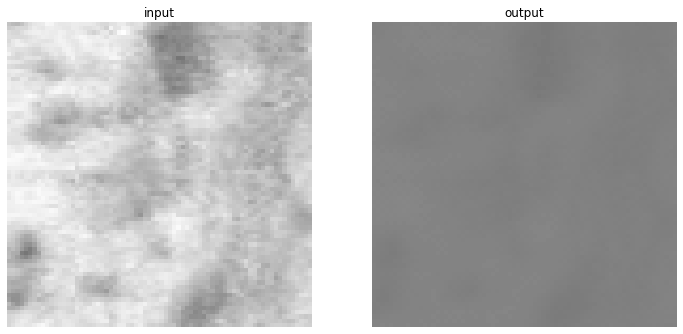

In [13]:
# view results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))                                                                                       
plt.subplot(121)
plt.title("input")
plt.imshow(test_in[:,:,50], cmap="gray", vmin=0, vmax=255)                                                            
plt.axis('off')
plt.subplot(122)
plt.title("output")
plt.imshow(test_out[:,:,50], cmap="gray", vmin=0, vmax=255)                                                            
plt.axis('off')
plt.show() 